In [43]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Time series analysis in Python
dataset = pd.read_csv('/Users/coding/Documents/GitHub/TimeSeriesAnalysisWithPython/data/AirPassengers.csv')
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

In [106]:
indexedDataset

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


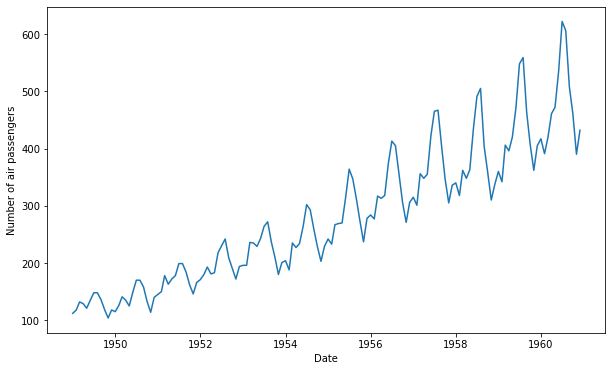

In [4]:
# Our data is not stationary as seen from the graph below. 
# Due to high growth in airline traffic, the mean is changing year over year.
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [5]:
rolmean = indexedDataset.rolling(window = 12).mean()
rolstd = indexedDataset.rolling(window = 12).std()

In [6]:
# The mean number of the airline passengers increases year over year
rolmean[12:]

,#Passengers
Month,
1950-01-01,126.916667
1950-02-01,127.583333
1950-03-01,128.333333
1950-04-01,128.833333
1950-05-01,129.166667
...,...
1960-08-01,463.333333
1960-09-01,467.083333
1960-10-01,471.583333


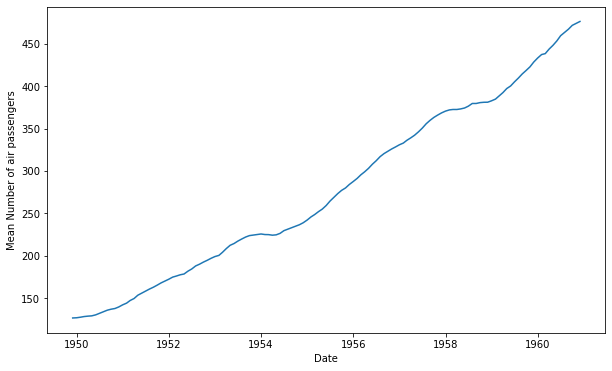

In [7]:
plt.xlabel('Date')
plt.ylabel('Mean Number of air passengers')
plt.plot(rolmean)

In [8]:
# The standard deviation is also increasing over all over time and 
# fluctuates up and down between years. 
rolstd[12:]

,#Passengers
Month,
1950-01-01,13.453342
1950-02-01,13.166475
1950-03-01,13.686977
1950-04-01,13.822467
1950-05-01,13.663710
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


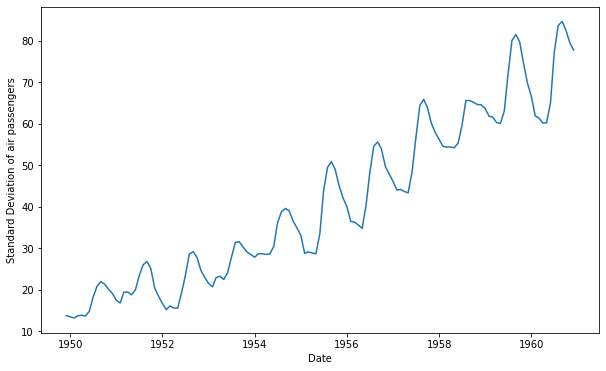

In [9]:
# As you can see, the standard deviation of air passengers increases overall 
# The standard deviation fluctuates between years in an up and down pattern.
plt.xlabel('Date')
plt.ylabel('Standard Deviation of air passengers')
plt.plot(rolstd)

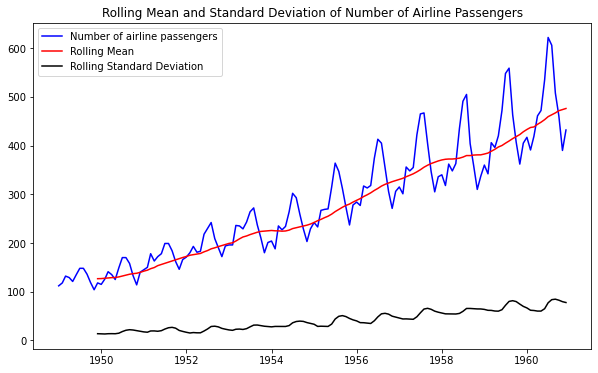

In [10]:
orig = plt.plot(indexedDataset, color = 'blue', label = 'Number of airline passengers')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation of Number of Airline Passengers')
plt.show(block=False)

In [11]:
Dickey_Fuller_Test = adfuller(indexedDataset['#Passengers'], autolag='AIC')
pd.Series(Dickey_Fuller_Test)

0                                             0.815369
1                                              0.99188
2                                                   13
3                                                  130
4    {'1%': -3.4816817173418295, '5%': -2.884041834...
5                                           996.692931
dtype: object

In [12]:
# The results of the Dickey Fuller Test show that the data is not stationary
Dickey_Fuller_Output = pd.Series(Dickey_Fuller_Test, index = 
          ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Test Statistics', 'Maximized Information Criterion'])

for key, value in Dickey_Fuller_Test[4].items():
    Dickey_Fuller_Output['Critical Value (%s)'%key] = value #Unpacking embeded critical value dictionary
    
Dickey_Fuller_Output = Dickey_Fuller_Output.drop('Test Statistics')
Dickey_Fuller_Output

Test Statistic                       0.815369
p-value                               0.99188
#Lags Used                                 13
Number of Observations Used               130
Maximized Information Criterion    996.692931
Critical Value (1%)                 -3.481682
Critical Value (5%)                 -2.884042
Critical Value (10%)                 -2.57877
dtype: object

In [13]:
#KPSS also shows that the data is not stationary.
#KPSS tests for stationarity around a deterministic trend
kpsstest = kpss(indexedDataset['#Passengers'], regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
kpss_output

Test Statistic           1.651312
p-value                  0.010000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

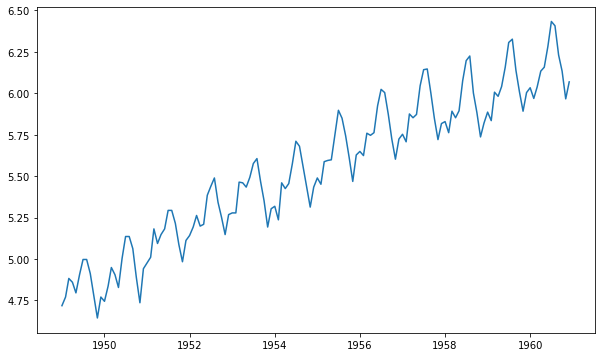

In [14]:
#Estimating Trend: The pattern has not changed
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

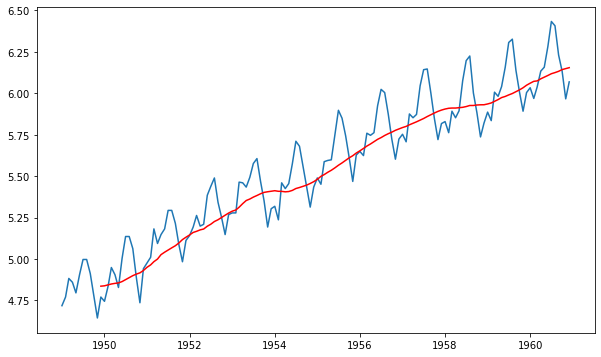

In [15]:
# The mean is still not stationary, however it is more stationary than before!
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingStd = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [16]:
# Make the time series stationary

LogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
LogScaleMinusMovingAverage.dropna(inplace=True)
LogScaleMinusMovingAverage.tail(10)

,#Passengers
Month,
1960-03-01,-0.036530
1960-04-01,0.046332
1960-05-01,0.060186
1960-06-01,0.175033
1960-07-01,0.315151
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230
1960-11-01,-0.182690


In [17]:
# Previously, I wanted to show each step in the process. 
# But, I can also put the code in functions like so.
# I will use these going forward to avoid repetitive code
 
def plot_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Number of Airline Passengers')
    mean = plt.plot(movingAverage, color = 'red', label = 'Rolling Mean')
    std = plt.plot(movingStd, color = 'black', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def test_stationarity(timeseries):
    Dickey_Fuller_Test = adfuller(timeseries['#Passengers'], autolag='AIC')

    Dickey_Fuller_Output = pd.Series(Dickey_Fuller_Test, index = 
          ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Test Statistics', 'Maximized Information Criterion'])

    for key, value in Dickey_Fuller_Test[4].items():
        Dickey_Fuller_Output['Critical Value (%s)'%key] = value #Unpacking embeded critical value dictionary

    Dickey_Fuller_Output = Dickey_Fuller_Output.drop('Test Statistics')
    return Dickey_Fuller_Output

def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return kpss_output
    

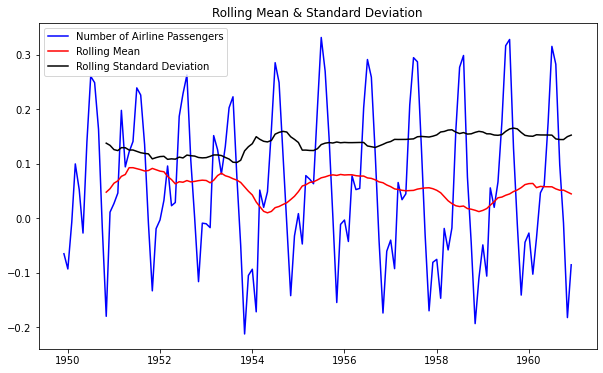

In [18]:
# Our data looks more stationary
plot_stationarity(LogScaleMinusMovingAverage)

In [19]:
#Augmented Dickey Fuller test
#Our p-value has decreased substantially. 
#We reject the null hypothesis that the data is non-stationary
test_stationarity(LogScaleMinusMovingAverage)

Test Statistic                      -3.162908
p-value                              0.022235
#Lags Used                                 13
Number of Observations Used               119
Maximized Information Criterion   -436.632695
Critical Value (1%)                 -3.486535
Critical Value (5%)                 -2.886151
Critical Value (10%)                -2.579896
dtype: object

In [20]:
#KPSS Test
#Cannot be used interchangeably with Dickey Fuller
#Tests for stationarity around a deterministic trend
kpss_test(LogScaleMinusMovingAverage)
#the data is basically stationary. We do not reject the null. 

Test Statistic           0.04306
p-value                  0.10000
#Lags Used               5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64

#### Exponential Decay Weighted Average

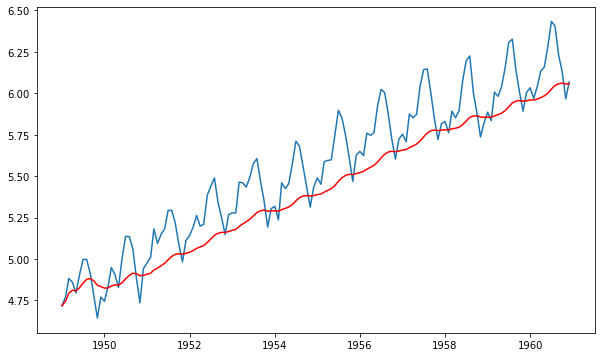

In [21]:
#Calculate the trend of the original time series
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife = 12, min_periods=0, adjust = True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

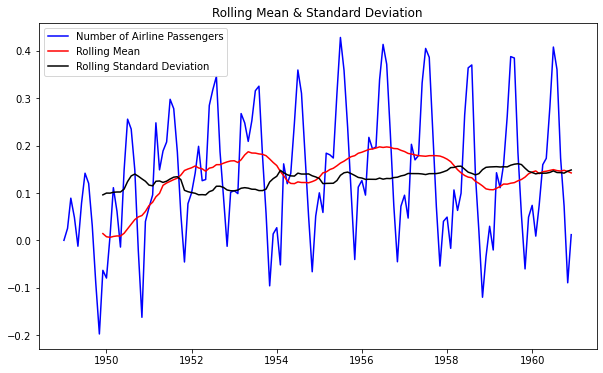

In [22]:
# Standard Deviation More Flat
# Rolling Mean is fairly stable between 0 and .2
# No trend in Number of Airline Passengers
LogScaleMinusExponentialDecayWeightedAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
plot_stationarity(LogScaleMinusExponentialDecayWeightedAverage)

In [23]:
#P-value is lower than previous when we subtracted moving average
#The data is stationary
#We reject the null hypothesis that the data is non-stationary
test_stationarity(LogScaleMinusExponentialDecayWeightedAverage)

Test Statistic                      -3.601262
p-value                              0.005737
#Lags Used                                 13
Number of Observations Used               130
Maximized Information Criterion   -462.824163
Critical Value (1%)                 -3.481682
Critical Value (5%)                 -2.884042
Critical Value (10%)                 -2.57877
dtype: object

In [24]:
#We do not reject the null that the data is stationary
kpss_test(LogScaleMinusExponentialDecayWeightedAverage)

Test Statistic           0.270752
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

#### Shift Data

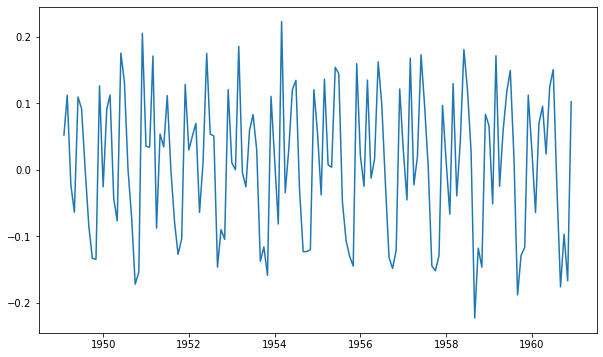

In [25]:
#Differentiating the time series by 1 
dataShifted = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(dataShifted)

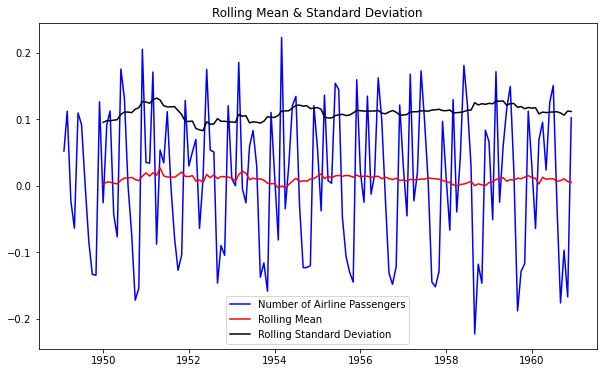

In [26]:
#Our data looks stationary but let's run the test in the next cell
dataShifted.dropna(inplace=True)
plot_stationarity(dataShifted)

In [27]:
#Our time series is basically stationary. 
#We reject the null hypothesis that the data is non-stationary
test_stationarity(dataShifted)

Test Statistic                     -2.717131
p-value                             0.071121
#Lags Used                                14
Number of Observations Used              128
Maximized Information Criterion   -440.35847
Critical Value (1%)                -3.482501
Critical Value (5%)                -2.884398
Critical Value (10%)                -2.57896
dtype: object

In [28]:
kpss_test(dataShifted) #We do not reject the null that the data is non-stationary

Test Statistic           0.038304
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

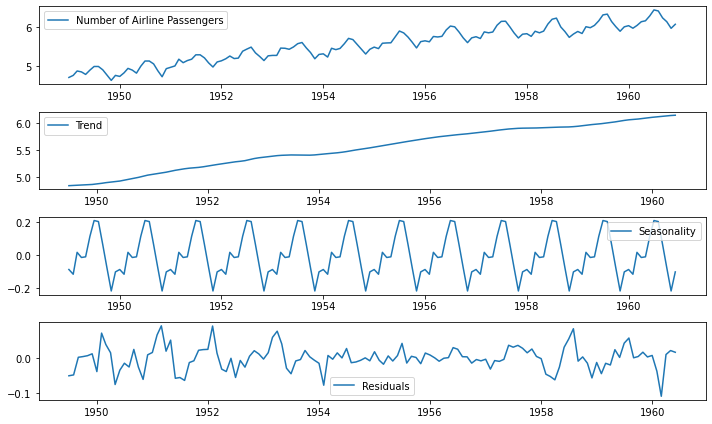

In [29]:
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label= 'Number of Airline Passengers')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [30]:
decomposedLogData = residual 
decomposedLogData.dropna(inplace=True) 

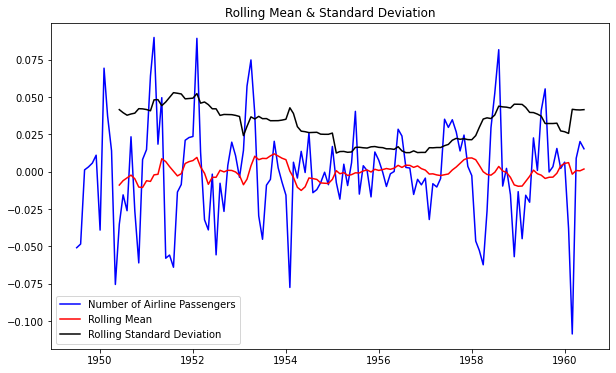

In [31]:
# High variation in residual between 1950 - 1954 & 1957 - 1960
# Lower variability between 1954 - 1957 which is interesting.
plot_stationarity(decomposedLogData)

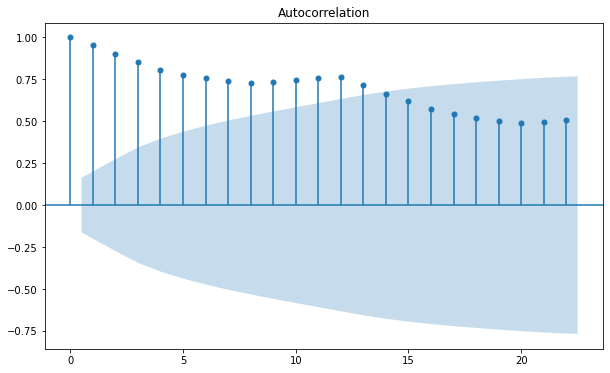

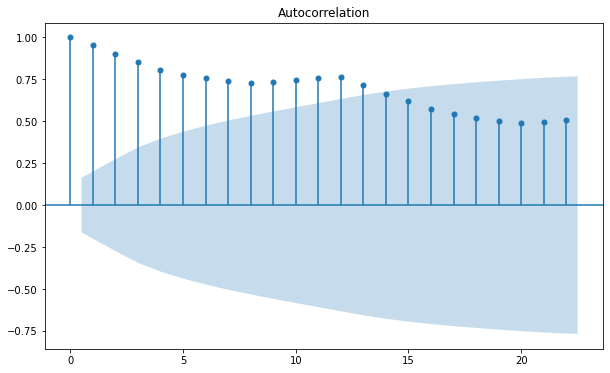

In [45]:
plot_acf(indexedDataset_logScale)
#Blue area is confidence interval

#### ARIMA 

In [32]:
# Auto ARIMA takes into account the AIC and BIC values generated 
#     to determine the best combination of parameters: 
#     AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).
# AIC uses the number of independent variables and 
#     the maximum likelihood estimate of the model to determine best fit.
#      The best-fit model is the one that explains the greatest amount of variation 
#      using the fewest possible independent variables.
# BIC has a larger penalty for more independent variables and involves
#      the number of observations in the formula
results = auto_arima(indexedDataset_logScale, trace=True, suppress_warnings=True)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-262.595, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-231.565, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-235.386, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-237.507, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-232.439, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-267.212, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-241.608, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-237.605, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-269.459, Time=0.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-236.952, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-248.753, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-269.823, Time=0.67 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-275.555, Time=0.84 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(4, 1, 3)   Log Likelihood                 151.331
Date:                Thu, 21 Apr 2022   AIC                           -284.662
Time:                        15:31:57   BIC                           -257.997
Sample:                             0   HQIC                          -273.827
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.002      6.597      0.000       0.009       0.016
ar.L1          0.2925      0.108      2.699      0.007       0.080       0.505
ar.L2         -0.3819      0.116     -3.279      0.001      -0.610      -0.154
ar.L3          0.4781      0.083      5.789      0.000       0.316       0.640
ar.L4         -0.5975      0.109     -5.479      0.000      -0.811      -0.384
ma.L1         -0.2656      0.168     -1.577      0.115      -0.596       0.065
ma.L2          0.0506      0.162      0.312      0.755      -0.267       0.368
ma.L3         -0.6967      0.155     -4.482      0.000      -1.001      -0.392
sigma2         0.0068      0.001      5.478      0.000       0.004       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.93   Prob(JB):                         0.38
Heteroskedasticity (H):               1.23   Skew:                             0.10
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model = ARIMA(indexedDataset_logScale, order = (4 , 1, 3))
results = model.fit()

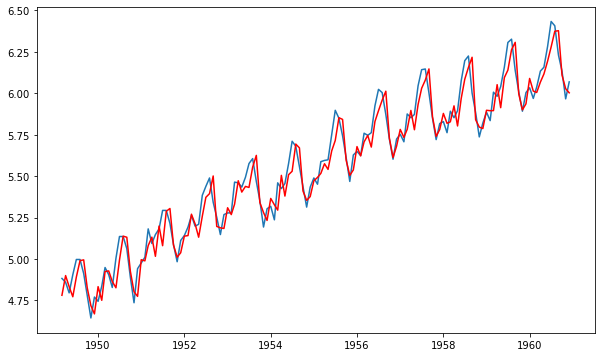

In [34]:
plt.plot(indexedDataset_logScale[2:])
plt.plot(results.fittedvalues[2:], color='red')

In [35]:
results.summary()
#Jarque-Bera test is a test for normality. 
# A goodness-of-fit test of whether sample data have the skewness and kurtosis 
# matching a normal distribution.
# A normal distribution has a skew of zero and a kurtosis of three.
# The skew is close to zero but the kurtosis is a little less than three.
# Prob(JB) = .57 means that we cannot reject the null the data is normally distributed.
# Ljung-Box: Test to see if any of a group of autocorrelations of a time series 
#            are different from zero.
# With a Prob(Q) of .4 we say that we cannot reject the null that there is NOT a lack of fit. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                 149.798
Date:                Thu, 21 Apr 2022   AIC                           -283.595
Time:                        15:31:58   BIC                           -259.893
Sample:                    01-01-1949   HQIC                          -273.964
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1720      0.130      1.324      0.186      -0.083       0.427
ar.L2         -0.4050      0.106     -3.816      0.000      -0.613      -0.197
ar.L3          0.5963      0.105      5.679      0.000       0.390       0.802
ar.L4         -0.5420      0.120     -4.499      0.000      -0.778      -0.306
ma.L1          0.0763      0.119      0.643      0.520      -0.156       0.309
ma.L2          0.2704      0.121      2.227      0.026       0.032       0.508
ma.L3         -0.7867      0.152     -5.169      0.000      -1.085      -0.488
sigma2         0.0069      0.001      5.354      0.000       0.004       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.40   Prob(JB):                         0.57
Heteroskedasticity (H):               1.14   Skew:                            -0.20
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
error = results.fittedvalues - indexedDataset_logScale['#Passengers']
errorsq = error**2
rss= errorsq.sum()
rss
#can also use from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(results.fittedvalues, indexedDataset_logScale))
print(rss, rmse)

23.289053764788818 0.4021561140070553


In [37]:
indexedDataset_logScale[2:].head()

,#Passengers
Month,
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
1949-06-01,4.905275
1949-07-01,4.997212


Text(0.5, 1.0, 'Fitted versus Original Values')

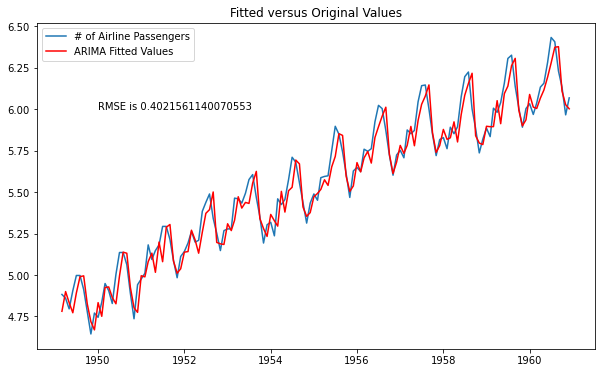

In [38]:
plt.plot(indexedDataset_logScale[2:], label='# of Airline Passengers')
plt.plot(results.fittedvalues[2:], color='red', label='ARIMA Fitted Values')
plt.legend(loc='best')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 6))
plt.title('Fitted versus Original Values')

In [39]:
preds = results.forecast(steps=20)
preds

1961-01-01    6.161459
1961-02-01    6.154707
1961-03-01    6.215827
1961-04-01    6.229114
1961-05-01    6.152194
1961-06-01    6.173685
1961-07-01    6.183327
1961-08-01    6.123217
1961-09-01    6.163476
1961-10-01    6.188847
1961-11-01    6.135840
1961-12-01    6.173031
1962-01-01    6.194203
1962-02-01    6.137427
1962-03-01    6.169990
1962-04-01    6.191053
1962-05-01    6.136159
1962-06-01    6.168375
1962-07-01    6.191058
1962-08-01    6.137766
Freq: MS, Name: predicted_mean, dtype: float64

In [40]:
#how to append one series on another
predictionsLog = pd.Series(indexedDataset_logScale['#Passengers'], index = indexedDataset_logScale.index)
predictionsLog = predictionsLog.add(preds, fill_value = 0)
predictionsLog

1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1962-04-01    6.191053
1962-05-01    6.136159
1962-06-01    6.168375
1962-07-01    6.191058
1962-08-01    6.137766
Length: 164, dtype: float64

In [41]:
predictions = np.exp(predictionsLog)
predictions #The data is now in its original form with predictions appended

1949-01-01    112.000000
1949-02-01    118.000000
1949-03-01    132.000000
1949-04-01    129.000000
1949-05-01    121.000000
                 ...    
1962-04-01    488.359874
1962-05-01    462.274450
1962-06-01    477.409570
1962-07-01    488.362333
1962-08-01    463.017826
Length: 164, dtype: float64

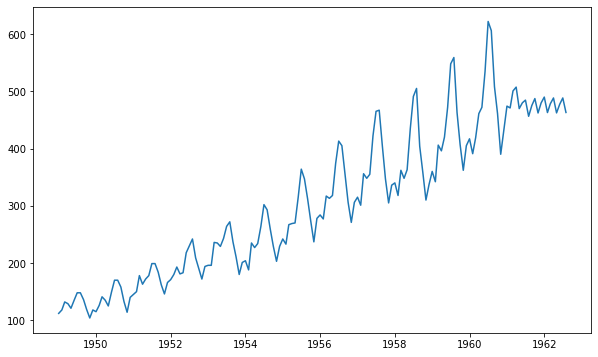

In [42]:
#plt.plot(indexedDataset)
plt.plot(predictions)

#### ARIMA with log scale minus moving average

In [51]:
results = auto_arima(LogScaleMinusMovingAverage, trace=True, suppress_warnings=True)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-277.447, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-152.169, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-233.989, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-246.526, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-133.698, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-252.154, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-279.238, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-254.090, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-260.142, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-277.308, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-261.472, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-285.263, Time=0.52 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-282.141, Time=0.54 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-267.794, Time=0.73 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(3, 0, 2)   Log Likelihood                 149.632
Date:                Thu, 21 Apr 2022   AIC                           -285.263
Time:                        16:35:09   BIC                           -265.031
Sample:                             0   HQIC                          -277.042
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0258      0.006      4.164      0.000       0.014       0.038
ar.L1          0.7863      0.155      5.081      0.000       0.483       1.090
ar.L2          0.2893      0.204      1.419      0.156      -0.110       0.689
ar.L3         -0.5326      0.129     -4.139      0.000      -0.785      -0.280
ma.L1          0.0982      0.121      0.814      0.416      -0.138       0.335
ma.L2         -0.7531      0.089     -8.496      0.000      -0.927      -0.579
sigma2         0.0061      0.001      5.762      0.000       0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 4.41
Prob(Q):                              0.58   Prob(JB):                         0.11
Heteroskedasticity (H):               1.06   Skew:                             0.08
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
model = ARIMA(LogScaleMinusMovingAverage, order = (3 , 0, 2))
results = model.fit()

In [58]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  133
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 149.632
Date:                Thu, 21 Apr 2022   AIC                           -285.265
Time:                        16:36:54   BIC                           -265.032
Sample:                    12-01-1949   HQIC                          -277.043
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0565      0.005     10.363      0.000       0.046       0.067
ar.L1          0.7863      0.154      5.101      0.000       0.484       1.088
ar.L2          0.2886      0.203      1.424      0.155      -0.109       0.686
ar.L3         -0.5308      0.128     -4.147      0.000      -0.782      -0.280
ma.L1          0.0980      0.120      0.818      0.414      -0.137       0.333
ma.L2         -0.7543      0.088     -8.564      0.000      -0.927      -0.582
sigma2         0.0061      0.001      5.764      0.000       0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 4.42
Prob(Q):                              0.59   Prob(JB):                         0.11
Heteroskedasticity (H):               1.07   Skew:                             0.08
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
results.fittedvalues

Month
1949-12-01    0.056477
1950-01-01   -0.026331
1950-02-01   -0.035629
1950-03-01    0.064324
1950-04-01    0.137993
                ...   
1960-08-01    0.246982
1960-09-01    0.169329
1960-10-01   -0.016472
1960-11-01   -0.048708
1960-12-01   -0.191300
Length: 133, dtype: float64

In [67]:
rmse = sqrt(mean_squared_error(results.fittedvalues, LogScaleMinusMovingAverage))
rmse

0.07859759654471396

In [68]:
LogScaleMinusMovingAverage.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


Text(0.5, 1.0, 'Fitted versus Original Values')

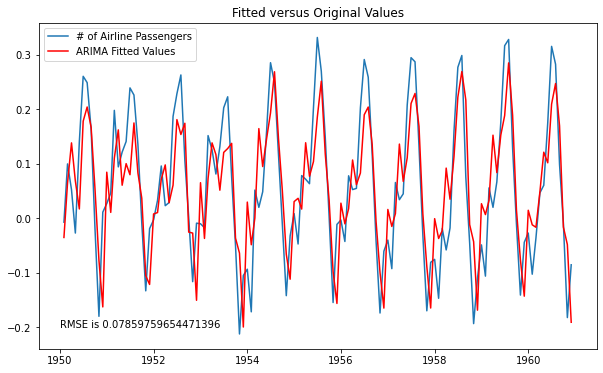

In [71]:
plt.plot(LogScaleMinusMovingAverage[2:], label='# of Airline Passengers')
plt.plot(results.fittedvalues[2:], color='red', label='ARIMA Fitted Values')
plt.legend(loc='best')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), -.2))
plt.title('Fitted versus Original Values')

In [72]:
preds = results.forecast(steps=20)
preds #Preds from 1961 - 1962

1961-01-01    0.021880
1961-02-01    0.035590
1961-03-01    0.105589
1961-04-01    0.107430
1961-05-01    0.121801
1961-06-01    0.096473
1961-07-01    0.079729
1961-08-01    0.051625
1961-09-01    0.038141
1961-10-01    0.028317
1961-11-01    0.031619
1961-12-01    0.038538
1962-01-01    0.050147
1962-02-01    0.059518
1962-03-01    0.066564
1962-04-01    0.068646
1962-05-01    0.067341
1962-06-01    0.063177
1962-07-01    0.058420
1962-08-01    0.054171
Freq: MS, Name: predicted_mean, dtype: float64

In [90]:
#how to append one series on another
predictionsLog = pd.Series(LogScaleMinusMovingAverage['#Passengers'], 
                           index = LogScaleMinusMovingAverage.index)
predictionsLog = predictionsLog.add(preds, fill_value = 0)
predDf = pd.DataFrame(predictionsLog, columns = ['preds'])

In [91]:
predDf['movingAverage'] = movingAverage

In [97]:
predDf.fillna(method='ffill', inplace=True) 
#Forward filling the last movingAverage for addition into predictions

In [98]:
predDf['undifferencing'] = predDf['preds'] + predDf['movingAverage']
predDf['expon'] = np.exp(predDf['undifferencing'])
predDf #The data is now in its original form with predictions appended

,preds,test,undifferencing,expon
1949-12-01,-0.065494,4.836178,4.770685,118.000000
1950-01-01,-0.093449,4.838381,4.744932,115.000000
1950-02-01,-0.007566,4.843848,4.836282,126.000000
1950-03-01,0.099416,4.849344,4.948760,141.000000
1950-04-01,0.052142,4.853133,4.905275,135.000000
...,...,...,...,...
1962-04-01,0.068646,6.154215,6.222861,504.143417
1962-05-01,0.067341,6.154215,6.221556,503.486264
1962-06-01,0.063177,6.154215,6.217392,501.393718
1962-07-01,0.058420,6.154215,6.212635,499.014598


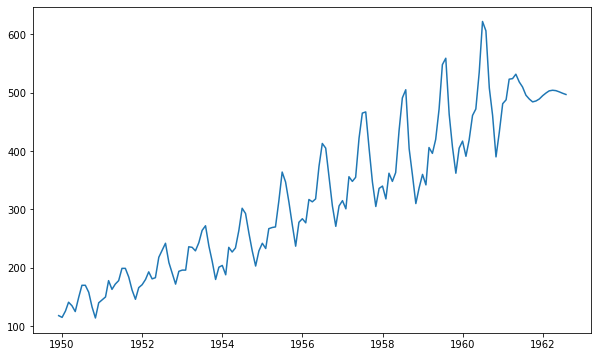

In [108]:
#plt.plot(indexedDataset)
plt.plot(predDf['expon'])